In [1]:
import os
import sys
sys.path.append('./src')
sys.path.append('../../') # to get bindings
#sys.path.append('./dependencies/indy-ros2/indy_description/urdf_files')

from utils import *
#from gato_mpc import *
from gato_mpc_batch_sample import *
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat.geometry as g
import meshcat.transformations as tf
import numpy as np
np.set_printoptions(linewidth=99999999)

# Load robot model
model_dir = "description/"
urdf_path = model_dir + "indy7.urdf"
model, visual_model, collision_model = load_robot_model(urdf_path, model_dir)

# Create MPC solver and optimizer
#controller = MPC_GATO(model, N=32, dt=0.01)
f_ext = np.array([10.0, 0.0, 0.0, 0.0, 0.0, 0.0])
controller_sample = MPC_GATO_Batch_Sample(model, N=32, dt=0.01, batch_size=64, 
                                   constant_f_ext=f_ext, resample_f_ext=True, 
                                   f_ext_std=5, f_ext_resample_std=0.2)

controller = MPC_GATO_Batch_Sample(model, N=32, dt=0.01, batch_size=1, 
                                   constant_f_ext=f_ext, resample_f_ext=False, 
                                   f_ext_std=0.0, f_ext_resample_std=0.0)



f_ext_batch:
[[  0.           0.           0.           0.           0.           0.        ]
 [ -4.47496145   1.11165255  -6.5050824    0.           0.           0.        ]
 [  4.21024552  12.94047377   1.34796494   0.           0.           0.        ]
 [  4.18290822  -6.48456373   4.23673854   0.           0.           0.        ]
 [ -9.54500328   0.67059556   1.56299522   0.           0.           0.        ]
 [  6.55876254   3.34257817   2.70495868   0.           0.           0.        ]
 [  1.58002209   5.93706289  -4.26094758   0.           0.           0.        ]
 [ -2.71433636  -4.97652885  -0.432081     0.           0.           0.        ]
 [  1.70277603   5.37114032   3.22329305   0.           0.           0.        ]
 [  2.34052559  -4.56945387  -8.00707178   0.           0.           0.        ]
 [  2.724801     8.96264067  -1.67691055   0.           0.           0.        ]
 [ -2.45854448   3.9298747   -2.8999565    0.           0.           0.        ]
 [ -1.92620499 

In [2]:
# initial state
#xstart = np.zeros(controller.nx)
xstart = np.hstack((np.zeros(controller.nq), np.zeros(controller.nv)))

# goal ee positions
endpoints = np.array([
    np.array(controller.eepos(np.array([0.34848965, 0.3, 0.84213701, 0.0, 0.0, 0.0]))),
    # np.array(controller.eepos(1.6*np.ones(controller.nq))),
    # np.array(controller.eepos(0.5*np.ones(controller.nq))),
    # #np.array(controller.eepos(np.zeros(controller.nq))),
    # np.array(controller.eepos(0.2*np.ones(controller.nq))),
    # #np.array(controller.eepos(np.zeros(controller.nq))), 
    # #np.array(controller.eepos(np.array([-3.0, 1.0, 1.0, 1.0, 0.0, 0.0]))),
    # np.array(controller.eepos(-0.5*np.ones(controller.nq))),
    # #np.array(controller.eepos(np.zeros(controller.nq))),
    # np.array(controller.eepos(-0.9*np.ones(controller.nq))),
    # #np.array(controller.eepos(np.zeros(controller.nq))),
    # np.array(controller.eepos(0.5*np.ones(controller.nq))),
    # np.array(controller.eepos(np.array([0.5, 1.5, 2.0, 0.0, 0.0, 0.0]))),
    
])


In [3]:

# Run MPC
q_trajectory_sample, mpc_stats_sample = controller_sample.run_mpc(xstart, endpoints, 0.005, 10)

Running MPC with 2000 steps, sim_dt: 0.005
Endpoints:
[[-0.50411789 -0.3815826   0.94470905]]
t:    0.000, goal dist:  0.62964, best_id: 41
t:    0.050, goal dist:  0.63425, best_id: 2
t:    0.100, goal dist:  0.64394, best_id: 27
t:    0.200, goal dist:  0.67451, best_id: 48
t:    0.350, goal dist:  0.75213, best_id: 42
t:    0.400, goal dist:  0.78758, best_id: 19
t:    0.550, goal dist:  0.93046, best_id: 3
t:    0.700, goal dist:  1.14123, best_id: 42
t:    0.800, goal dist:  1.30722, best_id: 39
t:    0.950, goal dist:  1.08497, best_id: 26
t:    1.100, goal dist:  0.53145, best_id: 9
t:    1.150, goal dist:  0.38553, best_id: 57
Reached final goal 0


In [4]:

# Run MPC
q_trajectory, mpc_stats = controller.run_mpc(xstart, endpoints, 0.005, 2)

Running MPC with 400 steps, sim_dt: 0.005
Endpoints:
[[-0.50411789 -0.3815826   0.94470905]]
t:    0.000, goal dist:  0.62964, best_id: 0
t:    0.050, goal dist:  0.63423, best_id: 0
t:    0.100, goal dist:  0.64403, best_id: 0
t:    0.200, goal dist:  0.67478, best_id: 0
t:    0.350, goal dist:  0.74572, best_id: 0
t:    0.400, goal dist:  0.77785, best_id: 0
t:    0.550, goal dist:  0.91004, best_id: 0
t:    0.700, goal dist:  1.10598, best_id: 0
t:    0.800, goal dist:  1.24976, best_id: 0
t:    0.950, goal dist:  1.00760, best_id: 0
t:    1.100, goal dist:  0.53827, best_id: 0
t:    1.150, goal dist:  0.41978, best_id: 0
t:    1.350, goal dist:  0.14907, best_id: 0
t:    1.400, goal dist:  0.12219, best_id: 0
t:    1.600, goal dist:  0.10262, best_id: 0
t:    1.650, goal dist:  0.10344, best_id: 0
Reached final goal 0


In [ ]:
for key in mpc_stats:
    print(key)
    print(mpc_stats[key])

In [ ]:
stats = controller.solver.get_stats()
for key in stats:
    print(key)
    print(stats[key])

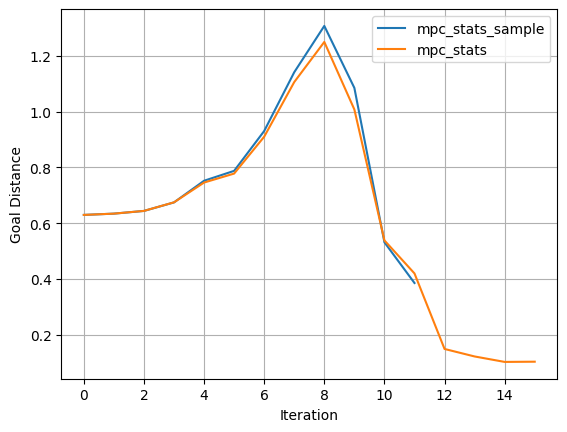

In [5]:
import matplotlib.pyplot as plt

# plot position error of mpc_stats_sample vs mpc_stats on same axis
fig, ax = plt.subplots()
ax.plot(mpc_stats_sample['goal_distances'], label='mpc_stats_sample')
ax.plot(mpc_stats['goal_distances'], label='mpc_stats')
ax.set_xlabel('Iteration')
ax.set_ylabel('Goal Distance')
ax.legend()
ax.grid(True)
plt.show()



In [ ]:
stats = controller.solver.get_stats()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(stats), 1, figsize=(5, 2*len(stats)))
if len(stats) == 1:
    axs = [axs]

for i, (key, data) in enumerate(stats.items()):
    ax = axs[i]
    if isinstance(data, dict) and 'values' in data:
        values = data['values']
        ax.plot(values, label=key)
        ax.set_title(f'{key} over iterations')
        if key == 'solve_time':
            ax.axhline(np.mean(values), color='r', linestyle='--', label=f'mean: {np.mean(values):.3f}')
            ax.text(0.02, 0.98, f'max: {np.max(values):.3f}\nmin: {np.min(values):.3f}', 
                   transform=ax.transAxes, verticalalignment='top')
    else:
        ax.plot(data, label=key)
        ax.set_title(f'{key} over iterations')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
    

In [7]:
# Setup pinocchio visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)
viz.initViewer()
viz.loadViewerModel()
# Visualize goals
for i, p in enumerate(endpoints):
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.06), 
        g.MeshLambertMaterial(color=0xff0000))

    T = tf.translation_matrix(np.array(p[:]))
    viz.viewer[f'point{i}'].set_transform(T)
#print_stats(controller.solver.get_stats())
while 1:
    #viz.play(q_trajectory=q_trajectory_sample, dt=0.01)
    viz.play(q_trajectory=q_trajectory, dt=0.01)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7019/static/


KeyboardInterrupt: 

In [ ]:
import pickle

print(q_trajectory)

# save trajectory to file
with open('q_trajectory.pkl', 'wb') as f:
    pickle.dump(q_trajectory, f)

In [3]:
ee_pos = np.load('eepos_g_batch.npy')
print(ee_pos)

[[0.34848965 0.3        0.84213701 0.         0.         0.         0.35093436 0.3        0.8368105  0.         0.         0.         0.35332343 0.3        0.8312704  0.         0.         0.         0.35565649 0.3        0.82552023 0.         0.         0.         0.35793316 0.3        0.81956363 0.         0.         0.         0.36015308 0.3        0.81340437 0.         0.         0.         0.3623159  0.3        0.80704637 0.         0.         0.         0.36442128 0.3        0.80049365 0.         0.         0.         0.36646888 0.3        0.79375037 0.         0.         0.         0.36845837 0.3        0.78682081 0.         0.         0.         0.37038945 0.3        0.77970936 0.         0.         0.         0.37226181 0.3        0.77242053 0.         0.         0.         0.37407515 0.3        0.76495894 0.         0.         0.         0.37582917 0.3        0.75732933 0.         0.         0.         0.37752362 0.3        0.74953653 0.         0.         0.         0.379158